In [88]:
import sys
import hashlib
import pandas as pd
import seaborn as sb


def load_txt(fn):
    d = pd.read_csv(fn, sep="\t", header=None)
    d.columns = ["CHROM", "POS", "NeighId", "SVLEN", "SVTYPE",
                 "TRFcopies", "TRFDiff", "TRFrepeat", "ALT"]
    def mk_key(line):
        result = hashlib.md5(f"{line['CHROM']} {line['POS']} {line['ALT']} {line['SVTYPE']}".encode())
        return result.hexdigest()

    d = d[(d["SVTYPE"] == 'INS') & (d["TRFDiff"] != ".")]
    d["var key"] = d.apply(mk_key, axis=1)
    d["TRFDiff"] = d["TRFDiff"].astype(float)
    d.set_index("var key", inplace=True)
    return d

def make_summary(base, other):
    cmp = base.join(other, rsuffix='cmp')
    parts = []
    for pos, i in enumerate(cmp.groupby(["NeighId", "TRFrepeat"])):
        base = i[1]["TRFDiff"].value_counts()
        other = i[1]["TRFDiffcmp"].value_counts(dropna=False)
        view = pd.concat([base, other], axis=1)
        view.reset_index(inplace=True)
        view.columns = ["copynum", "exactcnt", "othercnt"]
        view["loc key"] = pos
        parts.append(view)
    data = pd.concat(parts)
    rows = []
    for key, ck in data.groupby("loc key"):
        rows.append([key, 
                     (~ck["exactcnt"].isna()).sum(),
                     (ck["exactcnt"] > 1).sum(),
                     len(ck[(ck["othercnt"] > 1) & (~ck["exactcnt"].isna())]),
                     (ck["othercnt"].isna()).sum()])
    sum_dat = pd.DataFrame(rows, columns=["loc key", 
                                          "exact_cn_cnt",
                                          "exact_redund_vars",
                                          "other_redund_vars",
                                          "other_missing_cnt"]
                          )
    return sum_dat

In [91]:
exa = load_txt("trf_data/exact.txt.gz")
tru = load_txt("trf_data/truvari.txt.gz")
jas = load_txt("trf_data/jasmine.txt.gz")
sur = load_txt("trf_data/survivor.txt.gz")
nav = load_txt("trf_data/naive.txt.gz")

In [92]:
tru_sum = make_summary(exa, tru)
jas_sum = make_summary(exa, jas)
sur_sum = make_summary(exa, sur)
nav_sum = make_summary(exa, nav)

[Text(0.5, 1.0, 'Pre-Merge INS Tandem Repeat Loci'),
 Text(0.5, 0, 'Redundant Vars'),
 None,
 (0.0, 50.0)]

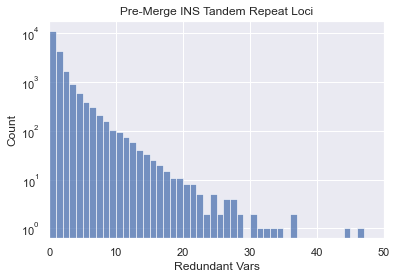

In [233]:
p = sb.histplot(data=tru_sum, x="exact_redund_vars", binwidth=1)
p.set(title="Pre-Merge INS Tandem Repeat Loci", xlabel="Redundant Vars", yscale="log", xlim=(0,50))

In [241]:
tru_sum.head()

,loc key,exact_cn_cnt,exact_redund_vars,other_redund_vars,other_missing_cnt
0,0,5,2,0,1
1,1,2,0,0,0
2,2,7,0,0,2
3,3,2,2,0,0
4,4,10,3,1,0


In [245]:
print("Total INS TR Loci", len(tru_sum["exact_redund_vars"]))
non_redund = tru_sum[tru_sum["exact_redund_vars"] == 0]
print("Non-Redundant Sites:", len(non_redund))
print("Non-Redundant Num Variants:", non_redund["exact_cn_cnt"].sum())

has_redund = tru_sum[tru_sum["exact_redund_vars"] != 0]
print("Redund Sites:", len(has_redund))
print("Redund Num Variants:", has_redund[["exact_redund_vars", "exact_cn_cnt"]].sum().sum())

Total INS TR Loci 20207
Non-Redundant Sites: 11151
Non-Redundant Num Variants: 20071
Redund Sites: 9056
Redund Num Variants: 91500


[Text(0.5, 1.0, 'Truvari-Merge Tandem Repeat Loci Count'),
 Text(0.5, 0, 'Redundant Vars'),
 None,
 (0.0, 50.0)]

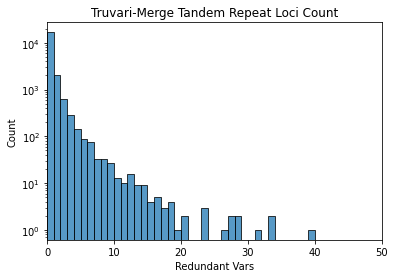

In [144]:
p = sb.histplot(data=tru_sum, x="other_redund_vars", binwidth=1)
p.set(title="Truvari-Merge Tandem Repeat Loci Count", xlabel="Redundant Vars", yscale="log", xlim=(0,50))

[Text(0.5, 1.0, 'Jasmine-Merge Tandem Repeat Loci Count'),
 Text(0.5, 0, 'Redundant Vars'),
 None,
 (0.0, 50.0)]

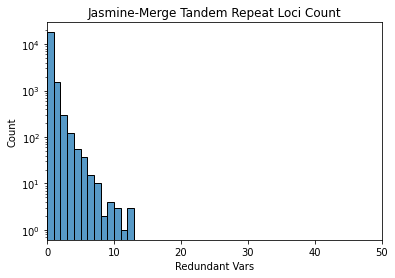

In [143]:
p = sb.histplot(data=jas_sum, x="other_redund_vars", binwidth=1)
p.set(title="Jasmine-Merge Tandem Repeat Loci Count", xlabel="Redundant Vars", yscale="log", xlim=(0,50))

[Text(0.5, 1.0, 'Survivor-Merge Tandem Repeat Loci Count'),
 Text(0.5, 0, 'Redundant Vars'),
 None,
 (0.0, 50.0)]

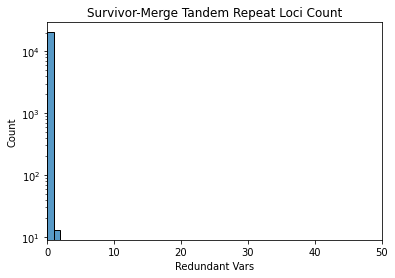

In [146]:
p = sb.histplot(data=sur_sum, x="other_redund_vars", binwidth=1)
p.set(title="Survivor-Merge Tandem Repeat Loci Count", xlabel="Redundant Vars", yscale="log", xlim=(0,50))

[Text(0.5, 1.0, 'Naive-Merge Tandem Repeat Loci Count'),
 Text(0.5, 0, 'Redundant Vars'),
 None,
 (0.0, 50.0)]

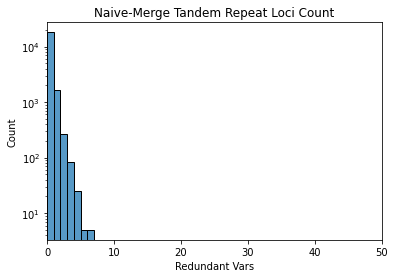

In [147]:
p = sb.histplot(data=nav_sum, x="other_redund_vars", binwidth=1)
p.set(title="Naive-Merge Tandem Repeat Loci Count", xlabel="Redundant Vars", yscale="log", xlim=(0,50))

[Text(0.5, 1.0, 'Naive-Merge Tandem Repeat Loci Count'),
 Text(0.5, 0, 'Redundant Vars'),
 None,
 (0.0, 50.0)]

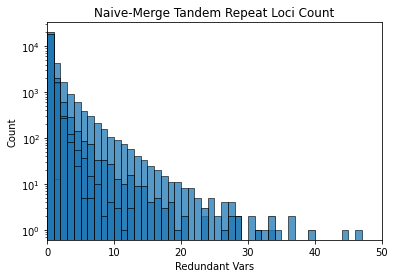

In [156]:
tru_sum.head()

,loc key,exact_cn_cnt,exact_redund_vars,other_redund_vars,other_missing_cnt
0,0,5,2,0,1
1,1,2,0,0,0
2,2,7,0,0,2
3,3,2,2,0,0
4,4,10,3,1,0


In [228]:
redund_data = []
for name, i in [("tru", tru_sum), ("jas", jas_sum), ("sur", sur_sum), ("nav", nav_sum)]:
    p = i[i["exact_redund_vars"] != 0][["other_redund_vars"]]
    p["name"] = name
    redund_data.append(p)
redund_data = pd.concat(redund_data).reset_index()

missing_data = []
for name, i in [("tru", tru_sum), ("jas", jas_sum), ("sur", sur_sum), ("nav", nav_sum)]:
    p = i[i["exact_redund_vars"] != 0][["other_missing_cnt"]]
    p["name"] = name
    missing_data.append(p)
missing_data = pd.concat(missing_data).reset_index()

In [250]:
redund_data["redund_bins"] = pd.cut(redund_data["other_redund_vars"], [0, 1, 100], 
                               labels=["None", "Any"], right=False)

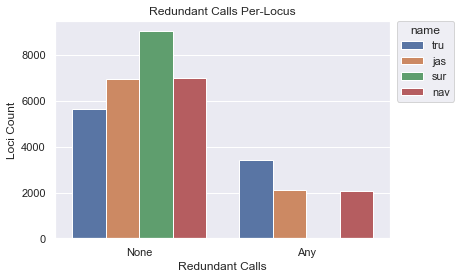

In [254]:
p = sb.countplot(data=redund_data, x="redund_bins", hue="name")#, multiple='stack')
sb.move_legend(p, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
hide = p.set(xlabel="Redundant Calls",
             title="Redundant Calls Per-Locus",
             ylabel="Loci Count")

In [346]:
missing_data.groupby(["name"])["other_missing_cnt"].describe(percentiles=[0.5, 0.99]).sort_values('mean')

,count,mean,std,min,50%,99%,max
name,,,,,,,
tru,9056.0,1.885159,3.702441,0.0,0.0,19.00,55.0
jas,9056.0,4.430543,6.607730,0.0,2.0,31.00,108.0
nav,9056.0,5.482774,7.927469,0.0,3.0,37.00,118.0
sur,9057.0,7.123772,8.215060,0.0,4.0,39.44,120.0


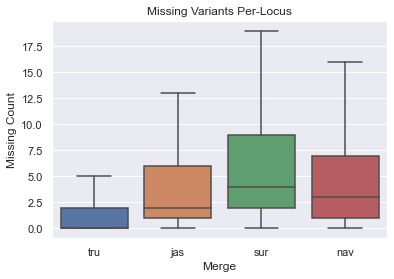

In [258]:
p = sb.boxplot(data=missing_data, y="other_missing_cnt", x="name", showfliers=False)
hide = p.set(title="Missing Variants Per-Locus", xlabel="Merge", ylabel="Missing Count")

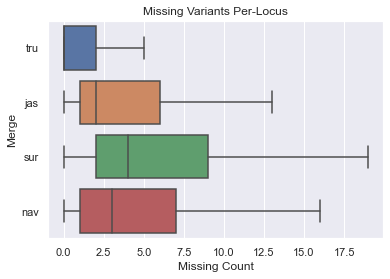

In [259]:
p = sb.boxplot(data=missing_data, x="other_missing_cnt", y="name", showfliers=False)
hide = p.set(title="Missing Variants Per-Locus", ylabel="Merge", xlabel="Missing Count")

[None]

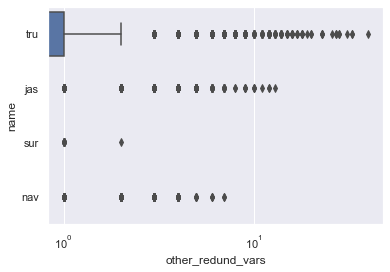

In [262]:
sb.boxplot(data=new_ps, x="other_redund_vars", y="name").set(xscale="log")